# Small convolutional network

### Imports

In [1]:
%matplotlib inline

import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Using TensorFlow backend.


In [2]:
# Dimensions of our images
img_width, img_height = 224, 224

n_classes = 25
train_data_dir = '../data/train'
validation_data_dir = '../data/validation'

### Data preprocessing

In [3]:
# Pixel values rescaling from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1. / 255)
batch_size = 32

# Retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

Found 40805 images belonging to 25 classes.
Found 8856 images belonging to 25 classes.


### Model architecture definition

A simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers

In [4]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Training

In [6]:
epochs = 100
# train_samples = 40805
# validation_samples = 8856
train_samples = 4080
validation_samples = 885

In [7]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='../models/basic_cnn.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=validation_generator,
        validation_steps=validation_samples // batch_size,)

Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.18519, saving model to ../models/basic_cnn_30_epochs.h5
81s - loss: 3.2570 - acc: 0.1233 - val_loss: 3.1358 - val_acc: 0.1852
Epoch 2/100
Epoch 00001: val_acc improved from 0.18519 to 0.29282, saving model to ../models/basic_cnn_30_epochs.h5
77s - loss: 2.5169 - acc: 0.3014 - val_loss: 2.5510 - val_acc: 0.2928
Epoch 3/100
Epoch 00002: val_acc improved from 0.29282 to 0.33218, saving model to ../models/basic_cnn_30_epochs.h5
77s - loss: 2.0697 - acc: 0.4190 - val_loss: 2.5726 - val_acc: 0.3322
Epoch 4/100
Epoch 00003: val_acc improved from 0.33218 to 0.38542, saving model to ../models/basic_cnn_30_epochs.h5
77s - loss: 1.9082 - acc: 0.4656 - val_loss: 2.2112 - val_acc: 0.3854
Epoch 5/100
Epoch 00004: val_acc improved from 0.38542 to 0.44444, saving model to ../models/basic_cnn_30_epochs.h5
79s - loss: 1.6932 - acc: 0.5224 - val_loss: 1.9638 - val_acc: 0.4444
Epoch 6/100
Epoch 00005: val_acc improved from 0.44444 to 0.47801, saving

### Evaluating on validation set

Computing loss and accuracy:

In [8]:
model.evaluate_generator(validation_generator, validation_samples, workers=12)

[1.3955558236959056, 0.66376873061317898]

Learning curve:

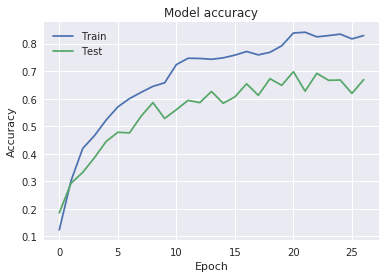

In [9]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('../images/basic_cnn.svg', format='svg', dpi=1200)

**After ~15 epochs the neural network reach ~65% accuracy. We can witness overfitting, no progress is made over validation set in the next epochs.**

### Saving the model as JSON

In [10]:
with open('../models/basic_cnn.json', 'w') as f:
    f.write(model.to_json())